In [22]:
!pip install catboost


In [40]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, Model
from sklearn.svm import SVC
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_score, recall_score,f1_score, auc
from tensorflow.keras import layers, models, regularizers, Input
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [24]:
df = pd.read_csv('Attrition.csv')

print(df.head())
print(df.info())
print(df.describe())
print(df.isnull().sum())


   Age Attrition     BusinessTravel  DailyRate              Department  \
0   41       Yes      Travel_Rarely       1102                   Sales   
1   49        No  Travel_Frequently        279  Research & Development   
2   37       Yes      Travel_Rarely       1373  Research & Development   
3   33        No  Travel_Frequently       1392  Research & Development   
4   27        No      Travel_Rarely        591  Research & Development   

   DistanceFromHome  Education EducationField  EmployeeCount  EmployeeNumber  \
0                 1          2  Life Sciences              1               1   
1                 8          1  Life Sciences              1               2   
2                 2          2          Other              1               4   
3                 3          4  Life Sciences              1               5   
4                 2          1        Medical              1               7   

   ...  RelationshipSatisfaction StandardHours  StockOptionLevel  \
0  ...

In [25]:
df.drop(['EmployeeNumber', 'EmployeeCount', 'Over18', 'StandardHours'], axis=1, inplace=True, errors='ignore')


In [26]:
# Copy df to avoid modifying original
data = df.copy()

# Encode categorical variables
le = LabelEncoder()
for col in data.select_dtypes(include=['object']).columns:
    data[col] = le.fit_transform(data[col])

# Features & Target
X = data.drop("Attrition", axis=1)
y = data["Attrition"]

# Scale features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# SMOTE for class imbalance

In [27]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_res.value_counts())

Before SMOTE: Attrition
0    986
1    190
Name: count, dtype: int64
After SMOTE: Attrition
0    986
1    986
Name: count, dtype: int64


# XGBoost

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:36:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Accuracy: 0.8469387755102041
              precision    recall  f1-score   support

           0       0.87      0.97      0.91       247
           1       0.56      0.21      0.31        47

    accuracy                           0.85       294
   macro avg       0.71      0.59      0.61       294
weighted avg       0.82      0.85      0.82       294



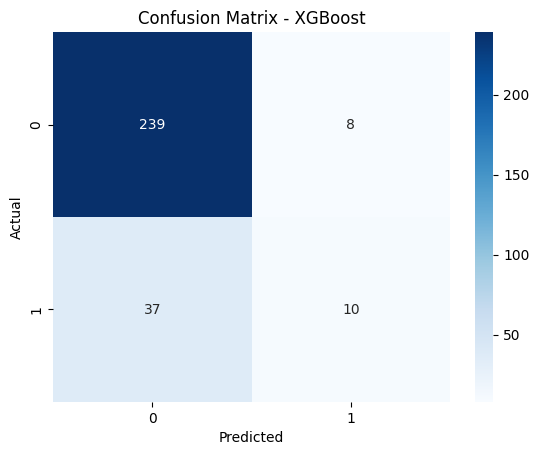

In [28]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# LightGBM

[LightGBM] [Info] Number of positive: 190, number of negative: 986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000164 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1149
[LightGBM] [Info] Number of data points in the train set: 1176, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.161565 -> initscore=-1.646632
[LightGBM] [Info] Start training from score -1.646632
LightGBM Accuracy: 0.8605442176870748
              precision    recall  f1-score   support

           0       0.87      0.98      0.92       247
           1       0.69      0.23      0.35        47

    accuracy                           0.86       294
   macro avg       0.78      0.61      0.64       294
weighted avg       0.84      0.86      0.83       294



/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


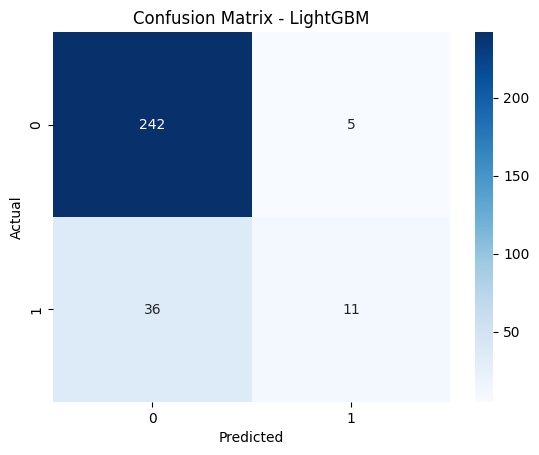

In [29]:
lgbm = LGBMClassifier(random_state=42)
lgbm.fit(X_train, y_train)
y_pred_lgbm = lgbm.predict(X_test)
print("LightGBM Accuracy:", accuracy_score(y_test, y_pred_lgbm))
print(classification_report(y_test, y_pred_lgbm))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred_lgbm), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - LightGBM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# CatBoost

CatBoost Accuracy: 0.8605442176870748
              precision    recall  f1-score   support

           0       0.87      0.99      0.92       247
           1       0.75      0.19      0.31        47

    accuracy                           0.86       294
   macro avg       0.81      0.59      0.61       294
weighted avg       0.85      0.86      0.82       294



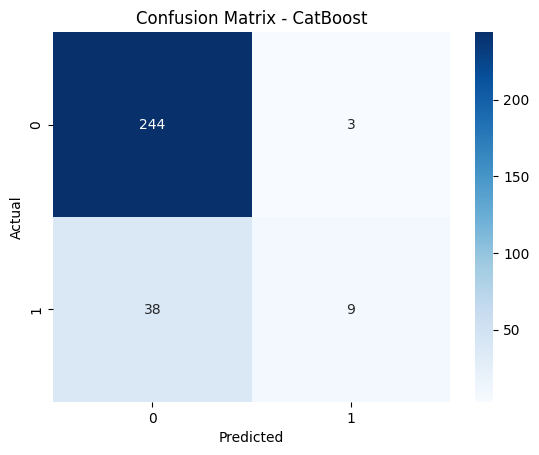

In [30]:
cat = CatBoostClassifier(verbose=0, random_state=42)
cat.fit(X_train, y_train)
y_pred_cat = cat.predict(X_test)
print("CatBoost Accuracy:", accuracy_score(y_test, y_pred_cat))
print(classification_report(y_test, y_pred_cat))

# Confusion Matrix Example for CatBoost
sns.heatmap(confusion_matrix(y_test, y_pred_cat), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - CatBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#SVM

SVM Accuracy: 0.8537414965986394
              precision    recall  f1-score   support

           0       0.86      0.98      0.92       247
           1       0.67      0.17      0.27        47

    accuracy                           0.85       294
   macro avg       0.76      0.58      0.59       294
weighted avg       0.83      0.85      0.82       294



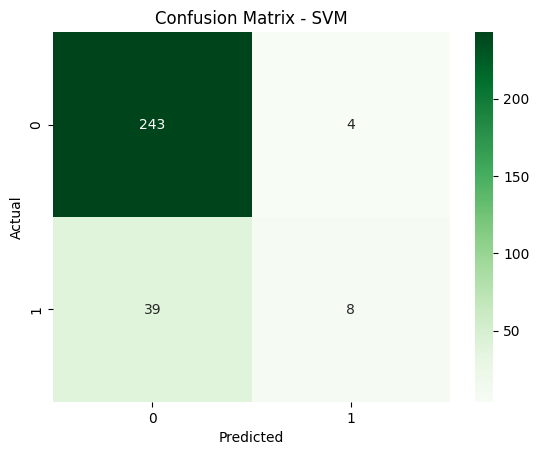

In [31]:
svm = SVC(kernel='rbf', random_state=42)  # you can also try 'linear' or 'poly'
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

# Confusion Matrix for SVM
sns.heatmap(confusion_matrix(y_test, y_pred_svm), annot=True, fmt="d", cmap="Greens")
plt.title("Confusion Matrix - SVM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# Random Forest

Random Forest Accuracy: 0.8367346938775511
              precision    recall  f1-score   support

           0       0.85      0.97      0.91       247
           1       0.46      0.13      0.20        47

    accuracy                           0.84       294
   macro avg       0.66      0.55      0.55       294
weighted avg       0.79      0.84      0.80       294



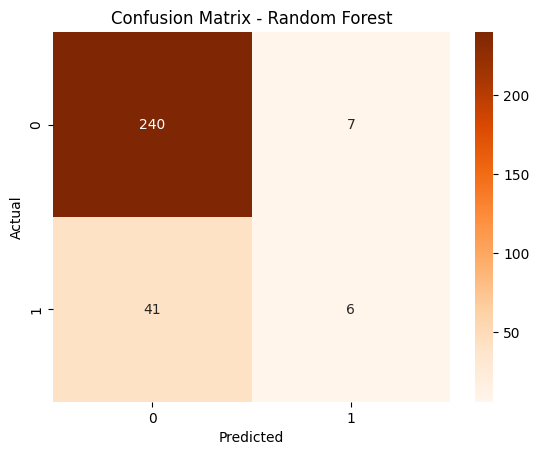

In [32]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

# Confusion Matrix for Random Forest
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt="d", cmap="Oranges")
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# Logistic Regression

Logistic Regression Accuracy: 0.8741496598639455
              precision    recall  f1-score   support

           0       0.89      0.97      0.93       247
           1       0.69      0.38      0.49        47

    accuracy                           0.87       294
   macro avg       0.79      0.68      0.71       294
weighted avg       0.86      0.87      0.86       294



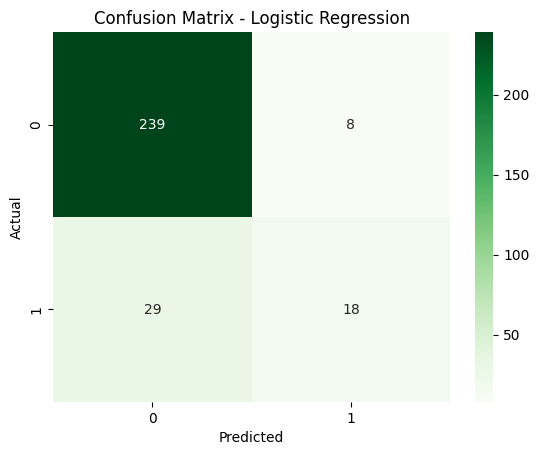

In [33]:

lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

# Confusion Matrix for Logistic Regression
sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt="d", cmap="Greens")
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# Comparison of results

In [41]:
results = []

models = {
    "Logistic Regression": lr,
    "Random Forest": rf,
    "SVM": svm,
    "XGBoost": xgb,
    "LightGBM": lgbm,
    "CatBoost": cat
}

for name, model in models.items():
    y_pred = model.predict(X_test)
    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-Score": f1_score(y_test, y_pred)
    })

results_df = pd.DataFrame(results)
print(results_df)

                 Model  Accuracy  Precision    Recall  F1-Score
0  Logistic Regression  0.874150   0.692308  0.382979  0.493151
1        Random Forest  0.836735   0.461538  0.127660  0.200000
2                  SVM  0.853741   0.666667  0.170213  0.271186
3              XGBoost  0.846939   0.555556  0.212766  0.307692
4             LightGBM  0.860544   0.687500  0.234043  0.349206
5             CatBoost  0.860544   0.750000  0.191489  0.305085


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


# ROC Curve

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


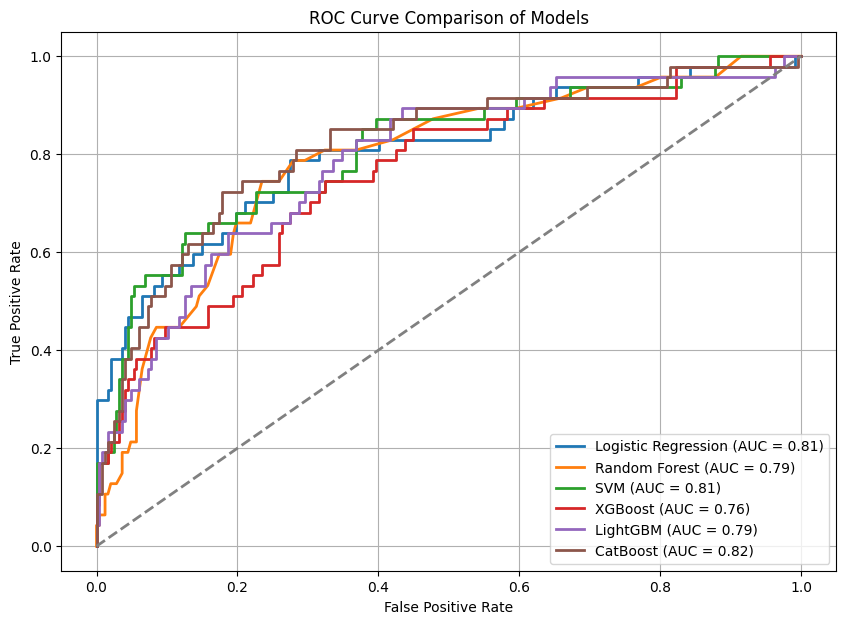

In [42]:
models = {
    "Logistic Regression": lr,
    "Random Forest": rf,
    "SVM": svm,
    "XGBoost": xgb,
    "LightGBM": lgbm,
    "CatBoost": cat
}

plt.figure(figsize=(10,7))

for name, model in models.items():
    # Some models need probability estimates
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)[:,1]
    else:  # e.g., SVM without probability=True
        y_score = model.decision_function(X_test)

    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

# Plot diagonal
plt.plot([0,1], [0,1], color='grey', linestyle='--', lw=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison of Models")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()